# Visualization of the computational experiment

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath('..'))
from constants.constants import RESULTS_FILE, RESULTS_BACKUP_FILE

### Fetching the results file

In [2]:
df = pd.read_csv(RESULTS_FILE, names=['NumProducts', 'Run', 'Encoding' , 'Time', 'OptValue', 'C', 'GroundRules', 'Variables', 'Constraints', 'Timeout'])
df = df.sort_values(by=['NumProducts', 'Run', 'Encoding'])
df

,NumProducts,Run,Encoding,Time,OptValue,C,GroundRules,Variables,Constraints,Timeout
169,6,0,asp,0.389848,480.0,480,22630.0,NaN,NaN,False
180,6,0,bad,0.037652,480.0,480,251.0,NaN,NaN,False
80,6,0,concorde,0.084202,NaN,480,NaN,NaN,NaN,False
243,6,0,ilp,0.287732,NaN,480,NaN,42.0,252.0,False
215,6,0,pddl,0.209738,480.0,480,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...
162,46,3,concorde,0.297750,NaN,2745,NaN,NaN,NaN,False
165,48,0,concorde,0.179315,NaN,2865,NaN,NaN,NaN,False
164,48,1,concorde,0.172548,NaN,2895,NaN,NaN,NaN,False
167,48,2,concorde,0.216251,NaN,2715,NaN,NaN,NaN,False


### Get Encodings and NumProducts

In [3]:
encodings = df['Encoding'].drop_duplicates().to_list()
encodings

['asp', 'bad', 'concorde', 'ilp', 'pddl', 'tsp']

In [4]:
runs = df['Run'].drop_duplicates().to_list()
runs

[0, 1, 2, 3]

In [5]:
numProducts = df['NumProducts'].drop_duplicates().to_list()
numProducts

[6,
 8,
 10,
 12,
 14,
 16,
 18,
 20,
 22,
 24,
 26,
 28,
 30,
 32,
 34,
 36,
 38,
 40,
 42,
 44,
 46,
 48]

### Check data sanity

In [6]:
for numProduct in numProducts:
    for run in runs:
        df_temp_numProduct = df[df['NumProducts'] == numProduct]
        df_temp_run = df_temp_numProduct[df_temp_numProduct['Run'] == run]
        df_temp_run_woT = df_temp_run[df_temp_run['Timeout'] == False]
        if len(df_temp_run_woT['C'].drop_duplicates().to_list()) > 1:
            print('ERROR')
            print(f'numProduct: {numProduct} run: {run}')
            print(df_temp_run_woT[['Encoding', 'C']])
            print()

### Preprocessing the data for plotting

In [7]:
data = {}
for encoding in encodings:
    data[encoding] = {
        'times': {'numProducts': [], 'lbs': [], 'ubs': [], 'means': []},
        'rules': {'numProducts': [], 'lbs': [], 'ubs': [], 'means': []},
        'variables': {'numProducts': [], 'lbs': [], 'ubs': [], 'means': []},
        'constraints': {'numProducts': [], 'lbs': [], 'ubs': [], 'means': []}
    }
    df_encoding = df[df['Encoding'] == encoding]
    for numProduct in numProducts:
        df_numProduct = df_encoding[df_encoding['NumProducts'] == numProduct]
        if not df_numProduct.empty:
            times = df_numProduct['Time'].to_list()
            lb = min(times)
            ub = max(times)
            mean = float(sum(times)) / len(times)
            if not pd.isna(mean):
                data[encoding]['times']['lbs'].append(lb)
                data[encoding]['times']['ubs'].append(ub)
                data[encoding]['times']['means'].append(mean)
                data[encoding]['times']['numProducts'].append(numProduct)
            
        df_numProduct_woT = df_numProduct[df_numProduct['Timeout'] == False]
        if not df_numProduct_woT.empty:
            rules = df_numProduct_woT['GroundRules'].to_list()
            lb = min(rules)
            ub = max(rules)
            mean = float(sum(rules)) / len(rules)
            if not pd.isna(mean):
                data[encoding]['rules']['lbs'].append(lb)
                data[encoding]['rules']['ubs'].append(ub)
                data[encoding]['rules']['means'].append(mean)
                data[encoding]['rules']['numProducts'].append(numProduct)
            
            rules = df_numProduct_woT['Variables'].to_list()
            lb = min(rules)
            ub = max(rules)
            mean = float(sum(rules)) / len(rules)
            if not pd.isna(mean):
                data[encoding]['variables']['lbs'].append(lb)
                data[encoding]['variables']['ubs'].append(ub)
                data[encoding]['variables']['means'].append(mean)
                data[encoding]['variables']['numProducts'].append(numProduct)
            
            rules = df_numProduct_woT['Constraints'].to_list()
            lb = min(rules)
            ub = max(rules)
            mean = float(sum(rules)) / len(rules)
            if not pd.isna(mean):
                data[encoding]['constraints']['lbs'].append(lb)
                data[encoding]['constraints']['ubs'].append(ub)
                data[encoding]['constraints']['means'].append(mean)
                data[encoding]['constraints']['numProducts'].append(numProduct)


## Creating plots

### Plot for computation time

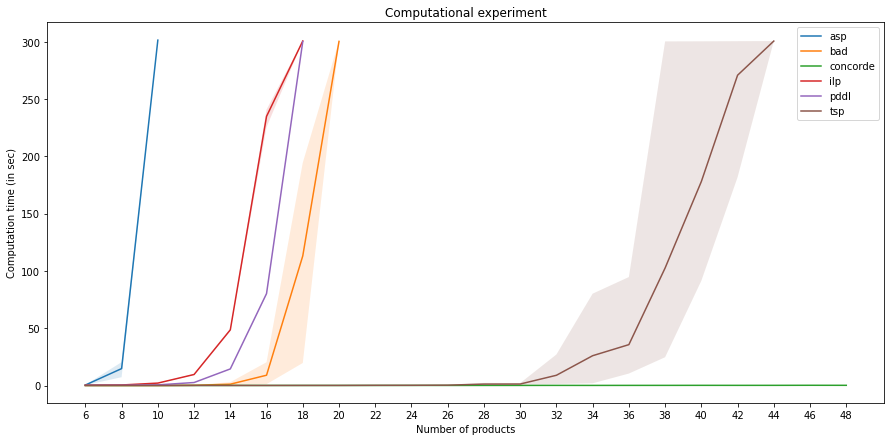

In [8]:
plt.figure(figsize=(15, 7))
plt.title('Computational experiment')
plt.xticks(numProducts)
plt.xlabel('Number of products')
plt.ylabel('Computation time (in sec)')

for encoding in encodings:
    if len(data[encoding]['times']['numProducts']) > 0:
        plt.plot(data[encoding]['times']['numProducts'], data[encoding]['times']['means'], label=encoding)
        plt.fill_between(data[encoding]['times']['numProducts'], data[encoding]['times']['lbs'], data[encoding]['times']['ubs'], alpha=0.15)

plt.legend()
plt.show()

### Plot for number of ground rules

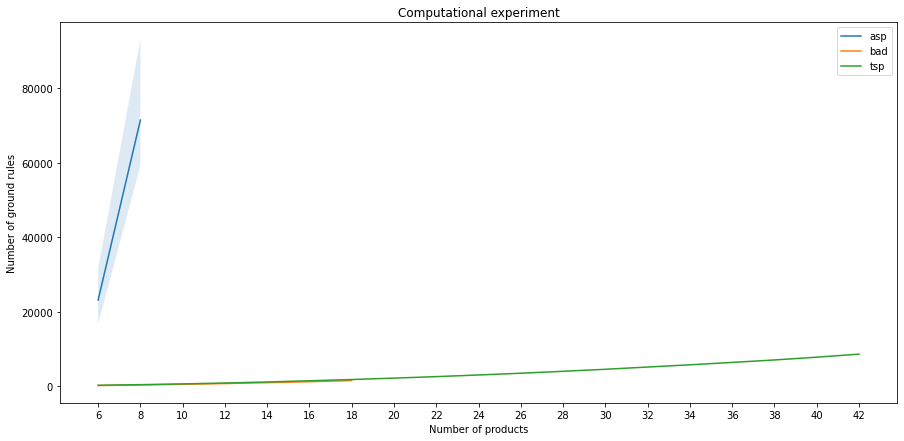

In [9]:
plt.figure(figsize=(15, 7))
plt.title('Computational experiment')
plt.xticks(numProducts)
plt.xlabel('Number of products')
plt.ylabel('Number of ground rules')

for encoding in encodings:
    if len(data[encoding]['rules']['numProducts']) > 0:
        plt.plot(data[encoding]['rules']['numProducts'], data[encoding]['rules']['means'], label=encoding)
        plt.fill_between(data[encoding]['rules']['numProducts'], data[encoding]['rules']['lbs'], data[encoding]['rules']['ubs'], alpha=0.15)

plt.legend()
plt.show()

### Plot for number of variables

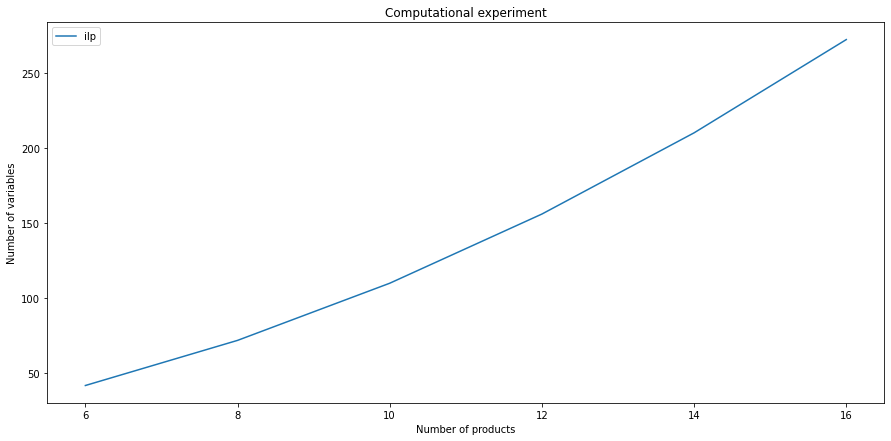

In [10]:
plt.figure(figsize=(15, 7))
plt.title('Computational experiment')
plt.xticks(numProducts)
plt.xlabel('Number of products')
plt.ylabel('Number of variables')

for encoding in encodings:
    if len(data[encoding]['variables']['numProducts']) > 0:
        plt.plot(data[encoding]['variables']['numProducts'], data[encoding]['variables']['means'], label=encoding)
        plt.fill_between(data[encoding]['variables']['numProducts'], data[encoding]['variables']['lbs'], data[encoding]['variables']['ubs'], alpha=0.15)

plt.legend()
plt.show()

### Plot for number of constraints

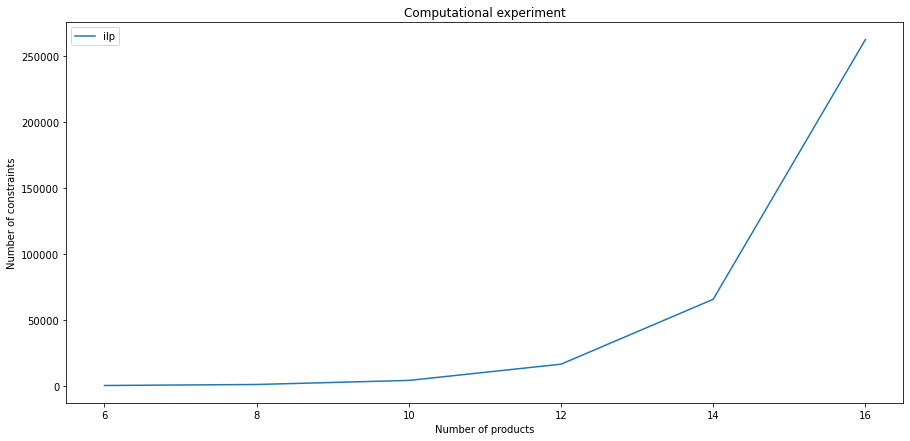

In [11]:
plt.figure(figsize=(15, 7))
plt.title('Computational experiment')
plt.xticks(numProducts)
plt.xlabel('Number of products')
plt.ylabel('Number of constraints')

for encoding in encodings:
    if len(data[encoding]['constraints']['numProducts']) > 0:
        plt.plot(data[encoding]['constraints']['numProducts'], data[encoding]['constraints']['means'], label=encoding)
        plt.fill_between(data[encoding]['constraints']['numProducts'], data[encoding]['constraints']['lbs'], data[encoding]['constraints']['ubs'], alpha=0.15)

plt.legend()
plt.show()